# Modelo Area de poligonos Convexos 
## Proyecto final Modelación y simulación II


Juan Sebastián Vargas Arévalo cod: 614221007
Sebastian Mantilla cod: 614221025
Nataly Neira Parra cod: 614212782

In [1]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix,mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC


 El presente  documento  muestra  las  generalidades del entrenamiento de un modelo de aprendisaje  supervisado  para determinar el área de un polígono  convexo. 
 
 # Alcances del modelo 
 
 *  El polígono  ingesado debe tener  vertices con coordenas en valores enteros  entre 0 y 5.
 *  El poligono debe  tener máximo  10  vertices.
 *  La clasificación es  un  proceso  separado, al calculo del área.
 *  La clasificación solo dice si es convexo o no.
 *  Las  áreas que predice  son una  aproximación de redondeo al entero superior.
 
Para la  clasificación del polígono se usara  **suport vector  machine**, y  para el cálculo del área  se usara **Redes  neuronales  convolucionales**, el set de datos   que  se  genera  debe  cumplir  tanto con  los parametros del alcance del modelo,  como con las  condiciones de entrada para cada uno de los metodos. 


## Definición y clasificación de polígonos 

Un polígono es una figura geométrica plana compuesta por una secuencia finita de segmentos de línea recta consecutivos que cierran una región en el plano. Estos segmentos se llaman lados, y los puntos de intersección de dos lados se llaman vértices [1].

Los poligonos  pueden  ser clasificados  de distintas  maneras, una  de ellas  es:

**Polígono Cóncavo**
Un polígono es cóncavo si al menos uno de sus ángulos interiores mide más de 180 grados. En otras palabras, tiene una "indentación" hacia el interior del polígono. Si se extiende una línea a lo largo de uno de los lados, al menos una parte de la línea pasa por el interior del polígono. 

**Polígono Estrellado**
Un polígono estrellado es un polígono que tiene la forma de una estrella y se caracteriza por sus intersecciones internas de lados que no son consecutivos. Esto crea una figura que parece una estrella, con múltiples vértices salientes y reentrantes. 
Puede ser considerado una forma de polígono cóncavo, ya que tiene ángulos interiores que suman más de 180 grados debido a las intersecciones internas.

**Polígono Convexo**
Un polígono es convexo si todos sus ángulos interiores son menores de 180 grados. Esto significa que ninguna línea que contiene un lado del polígono pasa por su interior. Los polígonos convexos no tienen "indentaciones"  lo que implica  que  coincide con el envolvente convexa de sus vértices.

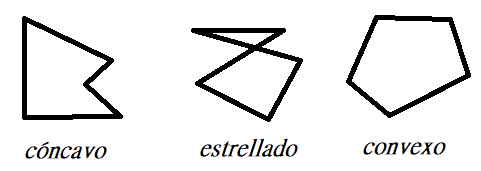


# Creación de datos de entrenamiento

Una  de las  partes  mas  importantes de  la implementación de este modelo de aprendzaje  supervisado, es la creación del conjunto de datos que se usara  como entrenamiento, para esto  se  crearan   poligonos  con puntos  aleatorios,  que  pueden ser  de las  tres clases  vistas anteriormente.  Como este modelo se enfoca en  poligonos  convexos,  se  tendra en cuenta que un poligono es convexo  si sus puntos  coinciden con la  envolvente conexa,  y  se clasificara cada  conjunto de puntos  generados  en  convexos (1) o  no convexos(0).

## Envolvente convexa

El envolvente convexo de un conjunto de puntos  $S$ en $n$ dimensiones es la intersección de todos los conjuntos convexos que contienen a $S$. Para $N$ puntos $ p_1, \ldots, p_N $, el envolvente convexo $C$ está dado por la expresión:

$$ C = \left\{ \sum_{i=1}^N \lambda_i p_i \mid \sum_{i=1}^N \lambda_i = 1, \lambda_i \geq 0 \, \text{para} \, \text{todo} \, i \right\} $$

Esta expresión define $ C$ como el conjunto de todas las combinaciones convexas de los puntos $ p_1, \ldots, p_N $[2].

En  python  La  función  **Scipy.Spatial.ConvexHull**  permite  encontrar la  envolvente  convexa  de  cualquier  set  de puntos. Esta  función usa algoritmos  geometricos  como el Quickhull, en donde  se  busca los puntos  extremos para  crear una  recta  que separa  el plano  luego  se elije el punto mas  distante a la  recta  en cada  subconjunto  formado, agregando  esos puntos al  set de puntos deseado,  se repite el proceso  generando  en cada  paso  una  envolvente convexa que se intersecta con la anterior, asegurando que al final la resultante sea el menor conjunto convexo que contiene a todo el set de puntos  original [3]. 
 

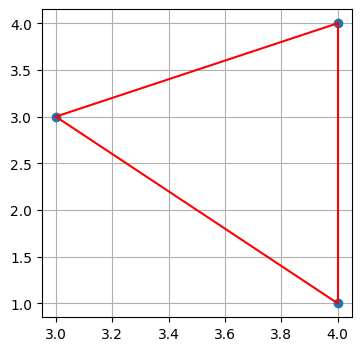

In [2]:
puntos = []
numero_random_puntos = random.randint(3, 10)

def crear_punto():
    x = random.randint(0, 5)
    y = random.randint(0, 5)
    return (x, y)

for i in range(numero_random_puntos):
        puntos.append(crear_punto()) 

puntos = np.array(puntos)
hull = ConvexHull(puntos)   # se encuentra la  envolvente (set de puntos)

# vsualización
plt.figure(figsize=(4, 4))
plt.plot(puntos[:,0], puntos[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(puntos[simplex, 0], puntos[simplex, 1], 'r-')
plt.grid()
plt.show()

Para  un  buen entrenamiento del modelo  de clasificación es necesario  generar  cantidades  similares de   poligonos  convexos  y no convexos,  para  esto  despues de clasificar los puntos  generados, se almacenan en un conjuto de datos las coordenadas de estos; para el  poligono no  convexo  se tiene encuenta  todos los  puntos  generados  y  el poligono convexo unicamente los  encontrados  por el  *Convexhull*.

Dado que cada punto  consta de una  coordenada $(x,y)$  para  hacer el tratamiendo de  datos  correcto,  se  transforma esta  coordenada en una  variable  numérica  usando   cada  coordenada como digito de un  número.

$$(1,2)\rightarrow 12$$

 para la  coordenada  $(0,0)$ se toma el  valor $-1$. para que  pueda ser  dstingible de los puntos  vacios. 

In [3]:
df = pd.read_csv("array_support_df.csv")
df = df.iloc[:,1:]
df.head()

,1,2,3,4,5,6,7,8,9,10,convexo
0,35.0,3.0,52.0,20.0,43.0,12.0,0.0,0.0,0.0,0.0,0.0
1,3.0,20.0,52.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,41.0,10.0,-1.0,53.0,15.0,3.0,24.0,23.0,40.0,23.0,0.0
3,53.0,15.0,3.0,-1.0,40.0,0.0,0.0,0.0,0.0,0.0,1.0
4,43.0,25.0,25.0,31.0,45.0,35.0,43.0,24.0,0.0,0.0,0.0


Durante el almacenamiento de estos  datos,  puede  ocurrir  que las  entradas  queden  duplicadas  justo cuando el  conjunto de puntos  generados  coincide  con la  envolvente  convexa, o  que  exista un  registro  que tenga  vacios  si   los puntos  generados  aleatoriamente  son  todos  colineales,  es por eso que  para el conjunto de datos  es  necesario  que  se realize  un  *Data  cleaning* 


Una  vez pueda ser  clasificado el polígono  se procede al cálculo del area  para los  convexos,  para esta  parte del proceso  el conjunto de  datos de entrenamiento que se  usara  son  las  imagenes de los  poligonos  creados apartir  del *ConvexHull*,  para ello  se  usan  los   puntos  entregados  por la  función  y se  crean  los  vertices  entre ellos,  haciendo uso de la  ecuación de recta,  finalmente  se grafican los  segmentos  de  recta  correspondientes  a cada vertice.

Dado los  alcances del  modelo, las  graficas de los  poligonos  siempre estan en la región del plano 

$A=\{ (x, y) \in \mathbb{R}^2 \mid 0 \leq x \leq  5 \text{ y } 0 \leq y \leq  5 \}$, 

Lo  cual estandarisa el tamaño de las  imagenes.

cada imagen es  clasificada  y almacenada  según el area  del polígono  que  contenga, en  carpetas  distintas. 


**#espacio  para  poner una imagen  de muestra**



## Teorema Shoelace 

El teorema  de Shoelace  o  *la Fórmula del área de Gauss*  es un algoritmo  usado para calcular el área de un polígono simple,  con los pertices  como  $(x_1,y_1),(x_2,y_2),(x_3,y_3)...(x_i,y_i)$

$$\text{Área} = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1}) \right|$$

donde $(x_{n+1},y_{n+1})=(x_1,y_1)$  para  el cierre del polígono.

Dado que  el polígono en consideración  esta determinado por  las coordenadas de los  vertices,  se  realiza la implementación  en python para  calcular  dicha  área,  tenendo  en cuenta  que  si se tiene  menos de  3  vertices  el  valor  del  area   calculada sera de cero.  Esta  fomula  tambien contienen el caso  para  puntos  colineales  y el área  calculada  es  cero. 


In [4]:
def shoelace_area(vertices):

    vertices = list(dict.fromkeys(vertices))
    
    if len(vertices) < 3:
        return 0

    def ordenar_puntos(vertices):
        centro_x = sum([v[0] for v in vertices]) / len(vertices)
        centro_y = sum([v[1] for v in vertices]) / len(vertices)
        
        def angulo(p):
            return math.atan2(p[1] - centro_y, p[0] - centro_x)
        
        return sorted(vertices, key=angulo)
    
    vertices = ordenar_puntos(vertices)
    vertices.append(vertices[0])

    S1 = 0
    S2 = 0

    for i in range(len(vertices) - 1):
        S1 += vertices[i][0] * vertices[i + 1][1]
        S2 += vertices[i][1] * vertices[i + 1][0]

    area = abs(S1 - S2) / 2
    
    return area

In [5]:
vertices=puntos[hull.vertices].tolist()
vertices = [tuple(vertex) for vertex in vertices]
print(" el area del polígono convexo encontrado es de {} u^2".format(shoelace_area(vertices)))

 el area del polígono convexo encontrado es de 1.5 u^2


Dado el alcance del  modelo   el área  encontrada  se redondea hacia  arriba  a  un valor  entero,  por lo tanto, las imagenes generadas estan clasificadas  unicamente en  26  carpetas: área cero, área 1, área 2, ..., área 25.  

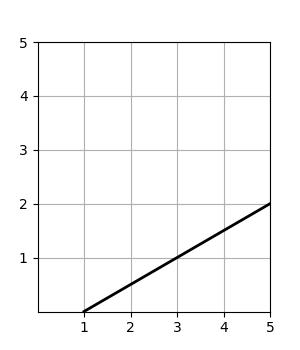
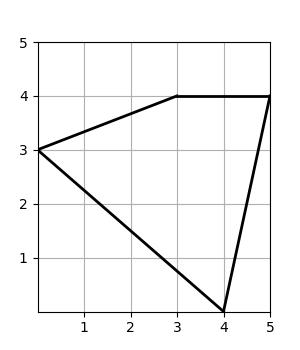
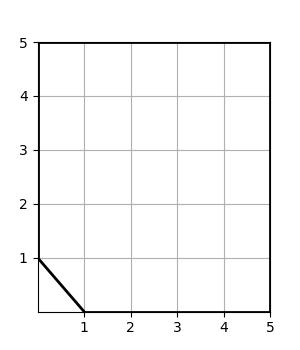

# Entrenamiento del modelo

 Como  se comento  anteriormente   el proseso de entrenamiento se separa en dos  partes:  una para el **support  vector  machine** y otra para las **redes  neuronales  convolucionales**
 
 ## Support  vector  machine 
  
 Support vector machine (SVM) es un algoritmo de aprendizaje supervisado. El objetivo del algoritmo SVM es encontrar un hiperplano que separe de la mejor forma posible dos clases diferentes de puntos de datos.

 “De la mejor forma posible”  implica que en la mayoría de los problemas prácticos, el algoritmo maximiza el margen flexible permitiendo un pequeño número de clasificaciones erróneas.

Para el uso de este clasificador  es necesario un Kernel, la funcion del kernel  es asignanar los datos a un espacio dimensional diferente,para  que resulte más fácil separar las clases, sin tener que transformal  los  datos especificamente [5].

Para la  finalidad  de  este modelo se usara el  kernel polinomial  de  grado  3 

**Polinomica**
$$K(x_1,x_2)=(x^T_1x_2+1)^ρ$$


Dado que  este clasificador está formulado para la clasificación binaria,  resulta ser una  buena  elección  para el  modelo  ya que  estamos  clasificando si son o no convexos.
 
 
 Para esta  clasificación  tomaremos el  dataframe creado con el conjunto de  datos,  donde las  primeras  10 columnas  representan los  vertices del poligonos  y la  última   determina  si es  o no  convexo,  recoordemos  que las  coordenas  de  cada punto  han sido  reemplazadas  por  un  entero repesentativo  entre 11 y 55.
 
 El conjunto de  datos  consta de $40.000$ entradas,  en este  punto  sin entradas  nulas  o  duplicadas. 
 
 Para el correcto entrenamiento del modelo  se escalaron los  datos  con el  método *StandardScaler* para evitar sesgos.
 

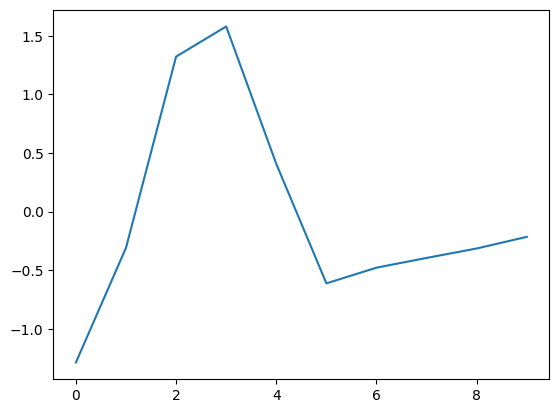

In [6]:
X = df.drop(columns=['convexo'])
y = df['convexo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.plot(X_test_scaled[123]) #  imprimir  datos  escalado  o una  representación de los mismos 


In [7]:
svm_classifier= SVC(kernel='poly',degree=3, C=5)
svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.82      0.88      1605
         1.0       0.89      0.98      0.93      2395

    accuracy                           0.91      4000
   macro avg       0.92      0.90      0.91      4000
weighted avg       0.92      0.91      0.91      4000



## Red  neuronal 

Las redes neuronales son modelos simples que  puede ser  usadas tanto en modelos de aprendizaje supervisado como en modelos de aprendizaje no supervisado, para  la  finalidad  de nuestro modelo, el aprendizaje  sera supervisado  dado que las redes neuronales son entrenadas con un conjunto de datos etiquetados, es decir, cada entrada del conjunto de datos está asociada con una salida o etiqueta correcta.

Este modelo trabaja al mismo tiempo con un gran número de unidades de procesamiento interconectadas que parecen versiones abstractas de las neuronas.

Las unidades de procesamiento, las  neuronas, se organizan en capas. pueden  haber tantas  capas  como uno  quiera  y tantas  neurnas  en cada capa  como se desee. Usualmente  estas  capas  de  dividen en: una capa de entrada, con unidades que representan los datos  o campos  de entrada; una o varias capas ocultas; y una capa de salida,las unidades que representa  las predicciones realizadas.  La  información  o datos  cambian  de capa  en capa, estas se interconecta  a travez  de  conexiones  variables  o ponderaciones, hasta llegar a la capa final  con el resultado  o  predicción [6].

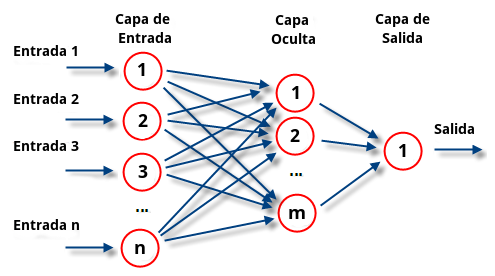

La  red  aprende examinando  cada registro  con  su respectiva predicción y  realiza los ajustes  necesarios al comparar lo predicho con el ejemplo entregado, para mejorar dicha  prediccción trasnmite la información  procedente de la  comparación hacia  atras  y cambia las ponderaciones  gradualmente.  Este  proceso se repite las  veces que sea  necesario (vueltas)  y el error  tiende a  disminuir  según   aumenta la  cantidad de  vueltas  que se den,  el proceso tiende a estabilizarse despues de un  número de vueltas.

### Tipos de redes

Existen distintos tipos de redes neuronales y  se  clasifican  dependiendo de cómo  fluyen  los datos de una capa a otra.

**Redes neuronales prealimentadas**

Este   tipo de redes procesan los datos  unidirecionalmente, desde el nodo de entrada hasta el nodo de salida. Todos los nodos de una capa están conectados a todos los nodos de la capa siguiente  y  usa la retroalimentación para mejorar las predicciones a lo largo del tiempo.

### Redes neuronales convolucionales

Las capas ocultas de las redes neuronales convolucionales realizan funciones matemáticas específicas, como la síntesis o el filtrado, denominadas convoluciones. Son muy útiles para la clasificación de imágenes porque pueden extraer características relevantes de las mismas. Cada capa oculta extrae y procesa diferentes características de la imagen, como los bordes, el color y la profundidad  lo cual mejora la  capacidad  de clasificacion en la predicción [7].

Usualmente este tipo de redes  consta de tres capas  especificas, aparte de las  generales  discutidas anteriormente:  convolucional, de agrupación y totalmente conectada. 

la capa final coincide con la capa totalmente conectada,  y esta conectada con  cada  capa  interior  esto le permite  identificar  partes cada vez más grandes de la imagen. Las primeras capas se centran en características simples, como colores y bordes. A medida que los datos de la imagen avanzan a través de las capas,  la  red comienza a reconocer elementos o formas más grandes hasta que finalmente identifica el objeto esperado.[8]



**Capa convolucional**

Este es el  bloque de  capas  principal la red, requiere algunos componentes como: datos de entrada, un filtro (o kernel) y un mapa de características.  el filtro permite reconocer caracteristicas particularesen la imagen,  se le llama proseso de convolucion  a recorrer la imagen e  identificar  si la caracteristica esta o no presente. 

Para  aplicar el filtro  usualmente es una matriz  3x3  que  se multiplica escalarmente con los pixeles de entrada de una parte  pequeña de la imagen,  luego se mueve  un poco  y repite la multiplicación ,  los  resultados de las  multiplicaciones  es el mapa de caracteristicas  o caracteristica  convolucionada. 

Esta  capa  requiere  3  hiper parametros que deben ser ajustados  según la  necesidad: El número de filtros, el stride  que es la distancia, o el número de píxeles, que el kernel mueve sobre la matriz de entrada; El zero-padding suele utilizarse cuando los filtros no se ajustan a la imagen de entrada.

Después de cada operación de convolución,a red aplica una transformación de unidad lineal rectificada (ReLU) al mapa de características, introduciendo la no linealidad en el modelo.

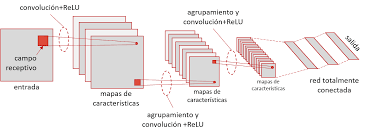

**Capa de agrupación**

También conocida como submuestreo, reduce el número de parámetros de la entrada. y al igual que la capa convolucional, esta  operacion recorre la imagen con un filtro pero sin peso, en su lugar,  aplica una función de agregación así  llena la matriz de salida. Hay dos tipos principales de agrupación: Máxima,  que envia el pixel con valor más  alto a la matriz de salida;  Media, envia el valor promedio de los pixeles 

Esta  capa ayuda a reducir la complejidad, mejora la eficiencia y limita el riesgo de sobreajuste. 

**Capa  totalmente conectada**

Como se nombro  anterior mente esta  suele  coincidir  con la capa de salida, y cada nodo de la capa de salida sí está conectado directamente a un nodo de la capa anterior. es en esta capa  que se realiza  la  clasificación  deacuerdo con las caracteristicas encontradas en las capas  anteriores. esta  capa  usa  una  función de activación sofmax  que  clasifica las  entradas  generando una probabilidad  entre 0 y 1.





## Funciones ReLU y Sofmax 

Las funciones ReLU  y Sofmax,  usadas  en las  distintas  capas de la red  convolucional  son  funciones de activación  que  tratan los  datos que salen de cada  una de las  neuronas antes de pasar  a la  siguiente capa,  es una  forma de tratar los datos  generados  de cada capas  excluyendo la linealidad  natural de la red, esto premite que se  realice predicciones  mas  variadas,  por lo tanto  una  de las caracteristicas  fundamentales de estas  funciones es que no sean lineales. 

ALgunas de las  funciones  más  frecuentes  son [9]:

* **La función sigmoidal** usada principalmente para  la clasificación binaria pues da resultados  entre  0 y 1.
* **La función tangente hiperbólica**  tiene un margen mas  amplio de clasificación  pues  da  valores ente -1 y 1 

Sin embargo,  estas  funciones  presentan  problemas de saturacion, algo que se  corrige en la  función más  usada.

* **ReLU**

la  función *Rectified Linear Unit* o ReLU simplemente rectifica los datos negativos y los vuelve cero a la salida. Las entradas con valores positivos no sufren modificación alguna.

$$\text{ReLU}(z) = 
\begin{cases} 
0 & \text{si } z \leq 0 \\
z & \text{si } z > 0 
\end{cases}$$


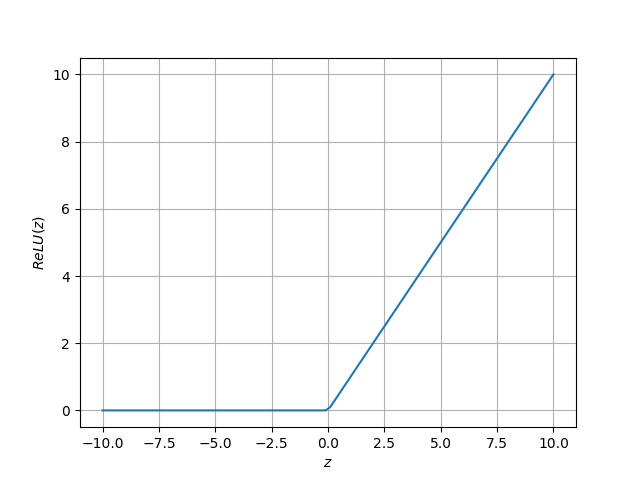

Esta  función  no tiene los problemas de saturación presentadas  en las dos  anteriores  y  es mucho mas  facil de implementar, reduciendo el coste computacional. Esta  es  usada unicamente en las  capas  oculatas, por lo tanto, para la capa de salida  debe  usarse una  función  distinta.

* **Sofmax**

La  función *Soft Maximum*  o Sofmax  es la  función por excelencia para usar en la capa de salida. Se usa para convertir un conjunto de valores en probabilidades que suman uno, especialmente en la  clasificación multiclase, estas probabilidades se utilizan para medir la confianza del modelo en la pertenencia a cada clase.


$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

donde $z_i$es el i-ésimo elemento del vector de entrada $Z$ y $n$ es el número total de elementos en el vector.

como se dijo anteriormente, esta  función es  muy util en la clasificación multiclase porque asigna una probabilidad a cada clase.  sin embargo  tiene  bastantes limitaciones para clasificaciones binarias. 

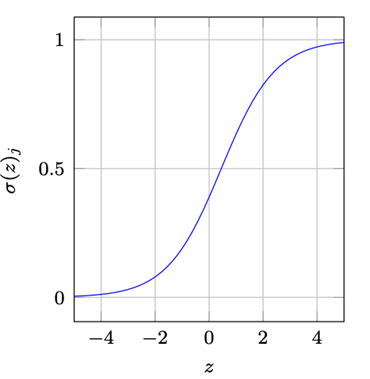

Aunque  su  forma  de resultado sea  muy parecida a la función sigmoidal , esta  es capaz de pproducir una distribución de probabilidad sobre todas las clases, y la  sigmoidal unicamente para clasficación  binaria. 





Para  este modelo  se usara La red  neuronal convolucional con $n$ capas  ocultas  cada una  con $m$ neuronas, en las  capas   convolucionales  se usa  la  funcion ReLU y en la  capa de salida la función Sofmax.

Se entrena la  red  con $20.000$  imagenes  de polígonos convexos  previamente clasificados en alguna de las  26  valores de áreas  considerados.

Se  hace uso de la  libreria  *TensorFlow*  para optimizar el  entrenamiento , desarrollo , evaluación y predicción del modelo  generado por la red.

# Una prueba del modelo
 
 En este  espacio  se permite  probar  ambas partes del modelo, clasificación  y cálculo,  dando un  conjunto de puntos  ordenados  que representan los  vertices de un polígono 
 
 Se recuerda  tener encuenta  el alcance del modelo: 
 
 *  El polígono  ingesado debe tener  vertices con coordenas en valores enteros  entre 0 y 5.
 *  El poligono debe  tener máximo  10  vertices.
 *  La clasificación es  un  proceso  separado, al calculo del área.
 *  La clasificación solo dice si es convexo o no.
 *  Las  áreas que predice  son una  aproximación de redondeo al entero superior.
 
Los  puntos  ingresados consecitivos, deben estar conectados  por una arista.
 
**Ejemplo**
  para el poligono 
  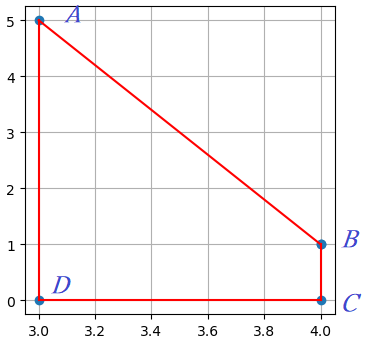
  
  Se debe ingresar  los  valores (3,5),(4,1),(4,0),(3,0)
  
 **Nota** : los  procesos de clasificación y cálculo del area  son independientes, por lo tanto,  aunque la clasificación sea no convexo, se  intentara  calcular el área.

In [ ]:
import ipywidgets as widgets
from IPython.display import display

text_box_num_points = widgets.Text(
    value='',
    placeholder='Número de puntos máximo 10',
    description='# de puntos',
    disabled=False
)

display(text_box_num_points)

text_boxes = []

def create_text_boxes(num_points):
    global text_boxes
    text_boxes = [] 
    for i in range(num_points):
        text_box = widgets.Text(
            value='(0,0)',
            placeholder='(0,0)',
            description=f'Punto {i+1}:',
            disabled=False
        )
        text_boxes.append(text_box)
        display(text_box)

submit_button_create = widgets.Button(
    description='Create Points',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)

def on_button_create_clicked(b):
    num_points = int(text_box_num_points.value)
    create_text_boxes(num_points)

submit_button_create.on_click(on_button_create_clicked)
display(submit_button_create)

submit_button_collect = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='',
    tooltip='Click me',
    icon='check'
)

lista_puntos_tupla = []

def on_button_collect_clicked(b):
    global lista_puntos_tupla
    lista_puntos_tupla = []
    for text_box in text_boxes:
        value = text_box.value.strip('()')  
        x, y = map(float, value.split(',')) 
        lista_puntos_tupla.append((int(x), int(y)))
    print(f'Lista submitted: {lista_puntos_tupla}')

submit_button_collect.on_click(on_button_collect_clicked)
display(submit_button_collect)


Text(value='', description='# de puntos', placeholder='Número de puntos máximo 10')

Button(description='Create Points', icon='check', style=ButtonStyle(), tooltip='Click me')

Button(description='Submit', icon='check', style=ButtonStyle(), tooltip='Click me')

Text(value='(0,0)', description='Punto 1:', placeholder='(0,0)')

Text(value='(0,0)', description='Punto 2:', placeholder='(0,0)')

Text(value='(0,0)', description='Punto 3:', placeholder='(0,0)')

Text(value='(0,0)', description='Punto 4:', placeholder='(0,0)')

Lista submitted: [(0, 0), (1, 0), (0, 1), (1, 1)]


[0. 1.] [0.0, 0.0]
[1, 1] [0. 1.]
[0. 1.] [1.0, 1.0]
[0, 0] [0. 1.]
[[-1. 10.  1. 11.  0.  0.  0.  0.  0.  0.  1.]
 [-1. 10. 11.  1.  0.  0.  0.  0.  0.  0.  1.]]


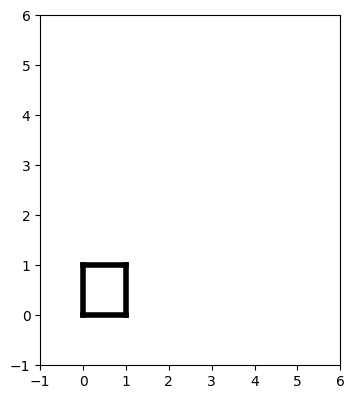

In [11]:
from crear_poli_copy import crear_poli

arr_support, arr_aux = crear_poli(lista_puntos_tupla)

array_support_final = np.empty((0,11))
array_support_final = np.vstack((array_support_final, arr_support))

array_support_final = np.vstack((array_support_final, arr_aux))
print(array_support_final)

In [12]:
pred_pred = svm_classifier.predict(array_support_final[:,:-1])

if pred_pred[0] == 1:
    print('Su polígono es convexo')
else:
    print('Su polígono no es convexo')

Su polígono no es convexo


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
[[7.79966265e-02 7.11906031e-02 1.44060785e-02 8.27942509e-03
  1.51407742e-03 4.71992942e-04 4.33044297e-05 1.75591758e-05
  1.63900841e-05 7.95922460e-05 3.80989695e-05 5.18819361e-05
  4.77740504e-02 2.71575627e-05 1.92419375e-05 5.81123168e-05
  6.37579506e-05 2.06206710e-06 2.48750090e-04 6.90424070e-02
  9.91856009e-02 7.34197199e-02 1.32943913e-01 2.10002154e-01
  1.45402104e-01 4.77053225e-02]]


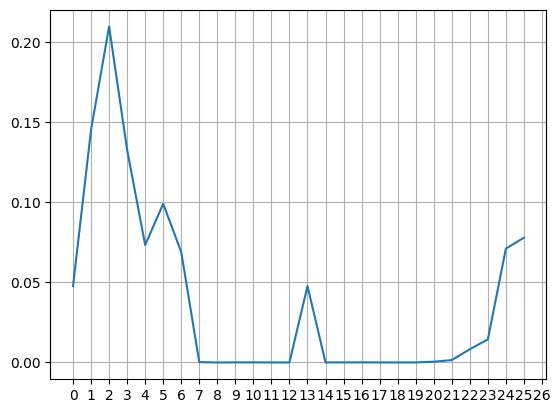

In [13]:
from predicción_redes import evaluar_cnn

pred_area = evaluar_cnn()

print(pred_area)
plt.plot(pred_area[0][::-1])
plt.xticks(ticks=np.arange(0, 27, 1)) 
plt.grid()

In [14]:
# vertices=puntos[hull.vertices].tolist()
# vertices = [tuple(vertex) for vertex in vertices]
print(" el area del polígono convexo encontrado es de {} u^2".format(shoelace_area(lista_puntos_tupla)))

 el area del polígono convexo encontrado es de 1.0 u^2


# Referencias

* [1] Wikipedia contributors. (2024). Polígono convexo. Wikipedia, The Free Encyclopedia. https://es.wikipedia.org/w/index.php?title=Pol%C3%ADgono_convexo&oldid=159357035

* [2] Weisstein, Eric W.(2024) "Convex Hull." From MathWorld--A Wolfram Web Resource. https://mathworld.wolfram.com/ConvexHull.html

* [3] Scipy.Spatial.ConvexHull — SciPy v1.13.1 manual. Scipy.org. Recuperado el 2 de junio de 2024, de https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html

* [4]  Art of Problem Solving. Shoelace Theorem. Artofproblemsolving.com. Recuperado el 2 de junio de 2024, de https://artofproblemsolving.com/wiki/index.php/Shoelace_Theorem

* [5] Support Vector Machine (SVM). Mathworks.com. Recuperado el 12 de mayo de 2024, de https://la.mathworks.com/discovery/support-vector-machine.html

* [6]  SPSS Modeler Subscription. (2021, agosto 17). Ibm.com. https://www.ibm.com/docs/es/spss-modeler/saas?topic=networks-neural-model

* [7] ¿Qué es una red neuronal? . Amazon.com. Recuperado el 3 de junio de 2024, de https://aws.amazon.com/es/what-is/neural-network/

* [8] ¿Qué son las redes neuronales convolucionales? (2024, mayo 29). Ibm.com. https://www.ibm.com/es-es/topics/convolutional-neural-networks

* [9] Sotaquirá, Miguel (2018) La Función de Activación. Codificando Bits.Recuperado el 3 de junio de 2024, de https://www.codificandobits.com/blog/funcion-de-activacion/

* [10] Función SoftMax: Activación para la clasificación. (2023, marzo 24). Jacar. https://jacar.es/funcion-softmax-activacion-para-la-clasificacion/















